In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.optim as optim
from xgboost import XGBClassifier

In [16]:


class EEGUtil:
    @staticmethod
    def load_data(file_path, column_name='spike hz'):
        """Load EEG data from a CSV file."""
        data = pd.read_csv(file_path)
        signal = data[column_name].values
        return signal

    @staticmethod
    def padding(signal, target_length):
        """Pad or truncate signal to the target length."""
        if len(signal) < target_length:
            return np.pad(signal, (0, target_length - len(signal)), 'constant', constant_values=-1)
        return signal[:target_length]

    @staticmethod
    def wavelet_transform(signal):
        """Perform Wavelet Transform and extract features."""
        coeffs = pywt.wavedec(signal, 'db4', level=5)
        features = []
        for i in range(1, len(coeffs)):
            features.extend([np.mean(coeffs[i]), np.std(coeffs[i])])
        return np.array(features)

    @staticmethod
    def psd_transform(signal, fs=0.2, nperseg=128):
        """Perform Power Spectral Density analysis and extract features."""
        freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
        return psd
    


In [30]:
import numpy as np
import pywt
from scipy.signal import welch
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


# 設置設備
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMVAE(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, latent_dim=10, num_layers=1):
        super(LSTMVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # 编码器
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # 解码器
        self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_output = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        _, (h, _) = self.encoder_lstm(x)
        h = h[-1]  # 提取最后一层的隐状态
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, seq_length):
        z = z.unsqueeze(1).repeat(1, seq_length, 1)  # 在时间维度上复制
        output, _ = self.decoder_lstm(z)
        return self.fc_output(output)

    def forward(self, x, lengths):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decode(z, x.size(1))  # 使用填充后的序列长度
        return recon_x, mean, logvar
    
    def get_embedding(self, x):
        mean, _ = self.encode(x)
        return mean


# 定义数据集类
class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, use_labels=False):
        self.data_folder = data_folder
        self.use_labels = use_labels
        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
        
        self.outcome_dict = {}
        if use_labels and outcome_file is not None:
            outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        patient_id = filename.split('.')[0]
        file_path = os.path.join(self.data_folder, filename)
        signal = EEGUtil.load_data(file_path, column_name='BCI')
        label = self.outcome_dict.get(patient_id, -1)
        return torch.tensor(signal, dtype=torch.float32).unsqueeze(1), label

import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import torch
from torch.nn.utils.rnn import pad_sequence

def train(model, dataloader, optimizer, criterion, alpha, kl_loss_enabled=True):
    model.train()
    running_loss = 0.0
    for data, _ in dataloader:
        # 计算每个序列的实际长度
        lengths = torch.tensor([len(seq) for seq in data], dtype=torch.long)
        data = pad_sequence(data, batch_first=True).to(device)  # 填充序列到等长
        
        # 前向传播
        optimizer.zero_grad()
        reconstruction, mean, logvar = model(data, lengths)  # 将长度信息传递给模型

        # 计算损失
        recon_loss = masked_mse_loss(reconstruction, data, lengths)
        kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
        loss = recon_loss + (alpha * kl_loss if kl_loss_enabled else 0)
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
    return running_loss / len(dataloader.dataset)

def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for data, _ in dataloader:
            lengths = torch.tensor([len(seq) for seq in data], dtype=torch.long)
            data = pad_sequence(data, batch_first=True).to(device)
            reconstruction, _, _ = model(data, lengths)
            loss = masked_mse_loss(reconstruction, data, lengths)
            running_loss += loss.item() * data.size(0)
    return running_loss / len(dataloader.dataset)

# 定义一个用于掩码填充部分的损失函数
def masked_mse_loss(predictions, targets, lengths):
    mask = torch.arange(targets.size(1), device=targets.device)[None, :] < lengths[:, None]
    mask = mask.float()
    loss = (predictions - targets) ** 2
    loss = loss * mask.unsqueeze(-1)  # 应用掩码，仅计算非填充部分
    return loss.sum() / mask.sum()  # 仅使用实际数据部分计算MSE


Epoch 1/100, Train Loss: 0.4726, Test Loss: 0.2595
Epoch 2/100, Train Loss: 0.1571, Test Loss: 0.0826
Epoch 3/100, Train Loss: 0.0781, Test Loss: 0.0645
Epoch 4/100, Train Loss: 0.0646, Test Loss: 0.0592
Epoch 5/100, Train Loss: 0.0628, Test Loss: 0.0588
Epoch 6/100, Train Loss: 0.0640, Test Loss: 0.0547
Epoch 7/100, Train Loss: 0.0653, Test Loss: 0.0555
Epoch 8/100, Train Loss: 0.0630, Test Loss: 0.0550
Epoch 9/100, Train Loss: 0.0671, Test Loss: 0.0551
Epoch 10/100, Train Loss: 0.0664, Test Loss: 0.0557
Epoch 11/100, Train Loss: 0.0648, Test Loss: 0.0535
Epoch 12/100, Train Loss: 0.0655, Test Loss: 0.0557
Epoch 13/100, Train Loss: 0.0655, Test Loss: 0.0542
Epoch 14/100, Train Loss: 0.0615, Test Loss: 0.0534
Epoch 15/100, Train Loss: 0.0632, Test Loss: 0.0549
Epoch 16/100, Train Loss: 0.0622, Test Loss: 0.0555
Epoch 17/100, Train Loss: 0.0638, Test Loss: 0.0583
Epoch 18/100, Train Loss: 0.0676, Test Loss: 0.0553
Epoch 19/100, Train Loss: 0.0633, Test Loss: 0.0560
Epoch 20/100, Train L

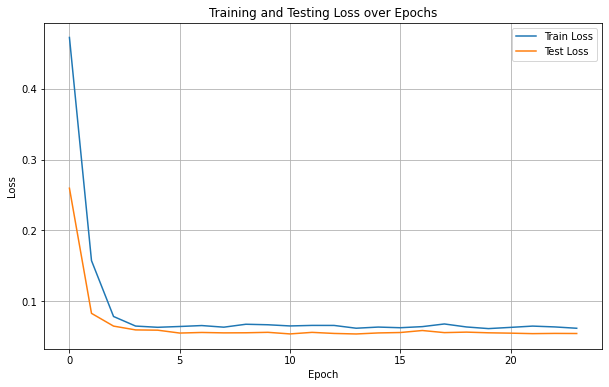

In [41]:
       

# 设置超参数和数据加载器
latent_dim = 10
batch_size = 32
epochs = 100
alpha = 1e-6
patience = 10
data_folder = '5min_smoothed_data/'
valid_outcome_data = 'valid_patients_outcome.csv'

# 创建数据集和数据加载器

eeg_dataset = EEGDataset(data_folder, valid_outcome_data)
train_size = int(0.8 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
# 自定义 collate_fn 函数以处理变长序列
def custom_collate_fn(batch):
    # batch 是一个包含多组 (data, label) 的列表
    data = [item[0] for item in batch]  # 提取数据
    labels = [item[1] for item in batch]  # 提取标签
    
    # 将数据和标签打包为元组列表
    return data, torch.tensor(labels, dtype=torch.long)

# 创建数据集和数据加载器
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
# 定义模型、损失函数和优化器
lstm_vae_model = LSTMVAE(input_dim=1, hidden_dim=64, latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_vae_model.parameters(), lr=1e-3, weight_decay=1e-4)

# 训练和测试
train_losses, test_losses = [], []
best_test_loss, epochs_no_improve = float('inf'), 0
for epoch in range(epochs):
    train_loss = train(lstm_vae_model, train_loader, optimizer, criterion, alpha)
    test_loss = test(lstm_vae_model, test_loader, criterion)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
def extract_latent_features(vae_model, dataset):
    latent_features = []
    labels = []

    for i in range(len(dataset)):
        signal, label = dataset[i]
        signal = signal.unsqueeze(0).to(device)

        # 将标签转换为数值
        numeric_label = 1 if label == "Good Outcome" else 0
        labels.append(numeric_label)

        # 获取潜在表示
        with torch.no_grad():
            latent_vector = vae_model.get_embedding(signal).cpu().numpy()
        latent_features.append(latent_vector.flatten())

    return np.array(latent_features), np.array(labels)

In [46]:
# 加载带有标签的数据集
eeg_dataset = EEGDataset(data_folder, valid_outcome_data, use_labels=True)

# 提取潜在特征和标签
latent_features, labels = extract_latent_features(lstm_vae_model, eeg_dataset)

In [47]:
# 确保 labels 是整数类型
labels = np.array(labels, dtype=int)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(latent_features, labels, test_size=0.3, stratify=labels, random_state=42)

# 打印类别分布
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

Training set class distribution: [172  36]
Testing set class distribution: [74 16]


In [48]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 创建并训练 SVM 模型
svm_model = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
svm_model.fit(X_train, y_train)

# 预测并评估模型
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of SVM on latent features: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy of SVM on latent features: 0.8000

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        74
           1       0.00      0.00      0.00        16

    accuracy                           0.80        90
   macro avg       0.41      0.49      0.44        90
weighted avg       0.67      0.80      0.73        90


Confusion Matrix:
[[72  2]
 [16  0]]


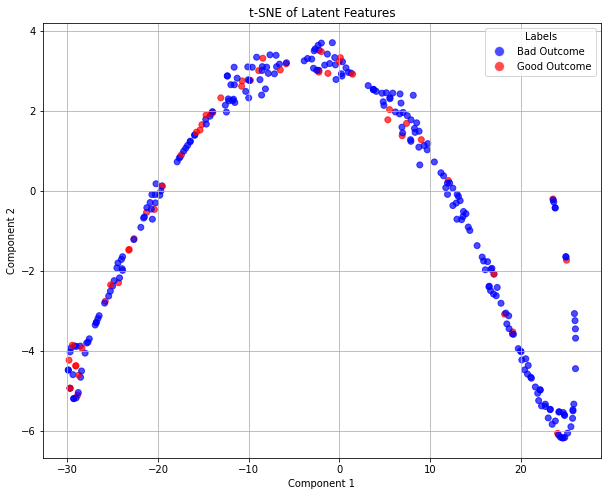

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_latent_space(latent_features, labels, method='pca'):
    """
    将潜在特征降维并可视化，指定颜色映射。
    
    参数：
    - latent_features: 2D numpy array，形状为 (样本数, 特征维度)
    - labels: 1D numpy array，样本标签
    - method: str, 降维方法 ('pca' 或 'tsne')
    """
    # 降维
    if method == 'pca':
        reducer = PCA(n_components=2)
        reduced_features = reducer.fit_transform(latent_features)
        title = "PCA of Latent Features"
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        reduced_features = reducer.fit_transform(latent_features)
        title = "t-SNE of Latent Features"
    else:
        raise ValueError("Method should be 'pca' or 'tsne'.")

    # 绘制散点图，指定颜色映射
    plt.figure(figsize=(10, 8))
    color_map = {0: 'blue', 1: 'red'}
    label_map = {0: 'Bad Outcome', 1: 'Good Outcome'}
    colors = [color_map[label] for label in labels]
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7, label=labels)
    
    # 创建自定义图例
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
    plt.legend(handles=handles, title="Labels")
    
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.show()

# 调用可视化函数
visualize_latent_space(latent_features, labels, method='tsne')# 可以将method设为'tsne'进行t-SNE可视化

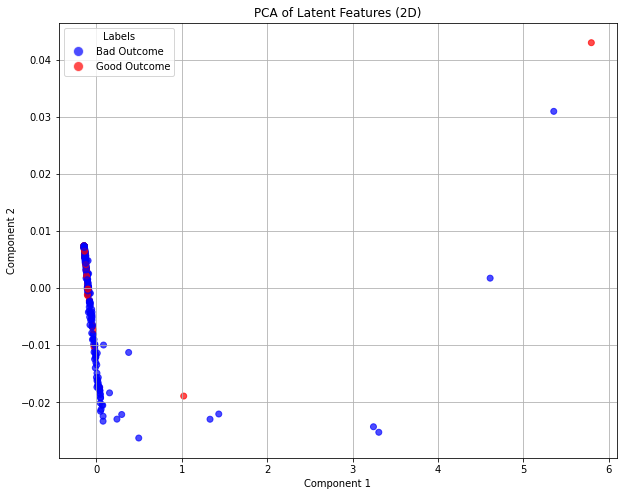

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D


def visualize_latent_space(latent_features, labels, method='pca', dimensions=2):
    """
    将潜在特征降维并可视化，支持二维或三维图形。
    
    参数：
    - latent_features: 2D numpy array，形状为 (样本数, 特征维度)
    - labels: 1D numpy array，样本标签
    - method: str, 降维方法 ('pca' 或 'tsne')
    - dimensions: int, 降维到2维或3维 (2或3)
    """
    if dimensions not in [2, 3]:
        raise ValueError("Dimensions must be 2 or 3.")

    # 降维
    if method == 'pca':
        reducer = PCA(n_components=dimensions)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"PCA of Latent Features ({dimensions}D)"
    elif method == 'tsne':
        reducer = TSNE(n_components=dimensions, random_state=42)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"t-SNE of Latent Features ({dimensions}D)"
    else:
        raise ValueError("Method should be 'pca' or 'tsne'.")

    # 可视化
    if dimensions == 2:
        # 二维散点图
        plt.figure(figsize=(10, 8))
        color_map = {0: 'blue', 1: 'red'}
        label_map = {0: 'Bad Outcome', 1: 'Good Outcome'}
        colors = [color_map[label] for label in labels]
        scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)
        
        # 创建自定义图例
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        plt.legend(handles=handles, title="Labels")
        plt.title(title)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.show()

    elif dimensions == 3:
        # 三维散点图
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        color_map = {0: 'blue', 1: 'red'}
        label_map = {0: 'Bad Outcome', 1: 'Good Outcome'}
        colors = [color_map[label] for label in labels]

        scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=colors, alpha=0.7)
        
        # 创建自定义图例
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        ax.legend(handles=handles, title="Labels")
        ax.set_title(title)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")
        
        # 启用交互式旋转
        plt.ion()  # 启用交互模式
        plt.show()
        
# 调用可视化函数
visualize_latent_space(latent_features, labels, method='pca', dimensions=2)  # 可设置'dimensions=2'或'dimensions=3'